# Predict Bike Sharing Demand with AutoGluon

## Download the Kaggle dataset using the kaggle python library

### Install packages

In [ ]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

### Setup Kaggle API Key

In [6]:
# create the .kaggle directory and an empty kaggle.json file
!mkdir -p /home/sagemaker-user/.kaggle
!touch /home/sagemaker-user/.kaggle/kaggle.json
!chmod 600 /home/sagemaker-user/.kaggle/kaggle.json

In [7]:
# Fill in your username and key from creating the kaggle account and API token file
import json
kaggle_username = "***"
kaggle_key = "***"

# Save API token the kaggle.json file
with open("/home/sagemaker-user/.kaggle/kaggle.json", "w") as f:
    f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [8]:
# Download the dataset, it will be in a .zip file, so we'll need to unzip it as well.
!kaggle competitions download -c bike-sharing-demand
# we use the -o flag to overwrite the file in case we already downloaded it
!unzip -o bike-sharing-demand.zip

  0%|                                                | 0.00/189k [00:00<?, ?B/s]
100%|████████████████████████████████████████| 189k/189k [00:00<00:00, 38.0MB/s]
Archive:  bike-sharing-demand.zip
  inflating: sampleSubmission.csv    
  inflating: test.csv                
  inflating: train.csv               


In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column, so we can use some of the `dt` features in pandas later
train = pd.read_csv("train.csv", parse_dates=["datetime"])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [3]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2011-12-27 05:56:22.399411968,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
min,2011-01-01 00:00:00,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2011-07-02 07:15:00,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,2012-01-01 20:30:00,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,2012-07-01 12:45:00,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,2012-12-19 23:00:00,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000
std,NaN,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [5]:
# Create the test pandas dataframe in pandas by reading the csv
test = pd.read_csv("test.csv", parse_dates=["datetime"])
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
# Same thing as train and test dataset
submission = pd.read_csv("sampleSubmission.csv", parse_dates=["datetime"])
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


## Train a model using AutoGluon’s Tabular Prediction

* We are prediting `count`, so it is the label we are setting.
* We ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* We use the `root_mean_squared_error` as the metric to use for evaluation.
* We set a time limit of 10 minutes (600 seconds).
* We use the preset `best_quality` to focus on creating the best model.

In [7]:
train.drop(columns=["casual", "registered"], inplace=True)

In [8]:
predictor = TabularPredictor(label="count",
                             eval_metric="root_mean_squared_error").fit(
    train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20240506_001728"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240506_001728"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   5.64 GB / 10.73 GB (52.5%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify t

[1000]	valid_set's rmse: 131.684
[2000]	valid_set's rmse: 130.67
[3000]	valid_set's rmse: 130.626
[1000]	valid_set's rmse: 135.592
[1000]	valid_set's rmse: 133.481
[2000]	valid_set's rmse: 132.323
[3000]	valid_set's rmse: 131.618
[4000]	valid_set's rmse: 131.443
[5000]	valid_set's rmse: 131.265
[6000]	valid_set's rmse: 131.277
[7000]	valid_set's rmse: 131.443
[1000]	valid_set's rmse: 128.503
[2000]	valid_set's rmse: 127.654
[3000]	valid_set's rmse: 127.227
[4000]	valid_set's rmse: 127.105
[1000]	valid_set's rmse: 134.135
[2000]	valid_set's rmse: 132.272
[3000]	valid_set's rmse: 131.286
[4000]	valid_set's rmse: 130.752
[5000]	valid_set's rmse: 130.363
[6000]	valid_set's rmse: 130.509
[1000]	valid_set's rmse: 136.168
[2000]	valid_set's rmse: 135.138
[3000]	valid_set's rmse: 135.029
[1000]	valid_set's rmse: 134.061
[2000]	valid_set's rmse: 133.034
[3000]	valid_set's rmse: 132.182
[4000]	valid_set's rmse: 131.997
[5000]	valid_set's rmse: 131.643
[6000]	valid_set's rmse: 131.504
[7000]	vali

	-131.4609	 = Validation score   (-root_mean_squared_error)
	49.31s	 = Training   runtime
	6.38s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 333.78s of the 533.81s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 130.818
[1000]	valid_set's rmse: 133.204
[1000]	valid_set's rmse: 130.928
[1000]	valid_set's rmse: 126.846
[1000]	valid_set's rmse: 131.426
[1000]	valid_set's rmse: 133.655
[1000]	valid_set's rmse: 132.155
[1000]	valid_set's rmse: 130.62


	-131.0542	 = Validation score   (-root_mean_squared_error)
	15.04s	 = Training   runtime
	1.39s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 315.39s of the 515.42s of remaining time.
	-116.5484	 = Validation score   (-root_mean_squared_error)
	18.98s	 = Training   runtime
	0.89s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 294.59s of the 494.63s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 4466.
	Ran out of time, early stopping on iteration 4357.
	Ran out of time, early stopping on iteration 4578.
	Ran out of time, early stopping on iteration 4516.
	Ran out of time, early stopping on iteration 4692.
	-130.5473	 = Validation score   (-root_mean_squared_error)
	245.73s	 = Training   runtime
	0.14s	 = Validation runtime
Fitting model: ExtraTreesMSE_BAG_L1 ... Training model for up to 48.56s of the 248.

[1000]	valid_set's rmse: 60.6785
[2000]	valid_set's rmse: 59.5282
[3000]	valid_set's rmse: 59.5463
[1000]	valid_set's rmse: 60.8425
[2000]	valid_set's rmse: 59.9701
[3000]	valid_set's rmse: 59.9381
[1000]	valid_set's rmse: 62.6342
[2000]	valid_set's rmse: 61.8629
[1000]	valid_set's rmse: 63.6108
[2000]	valid_set's rmse: 62.1397
[3000]	valid_set's rmse: 62.1457
[1000]	valid_set's rmse: 57.7306
[2000]	valid_set's rmse: 56.6823
[1000]	valid_set's rmse: 63.9981
[2000]	valid_set's rmse: 62.7132
[3000]	valid_set's rmse: 62.7294
[1000]	valid_set's rmse: 62.8312
[2000]	valid_set's rmse: 61.4156
[3000]	valid_set's rmse: 61.2991
[4000]	valid_set's rmse: 61.2196
[5000]	valid_set's rmse: 61.3319
[1000]	valid_set's rmse: 58.2427
[2000]	valid_set's rmse: 57.3959


	-60.1403	 = Validation score   (-root_mean_squared_error)
	54.03s	 = Training   runtime
	4.45s	 = Validation runtime
Fitting model: LightGBM_BAG_L2 ... Training model for up to 135.99s of the 135.97s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	-55.0269	 = Validation score   (-root_mean_squared_error)
	13.22s	 = Training   runtime
	0.36s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L2 ... Training model for up to 122.04s of the 122.02s of remaining time.
	-53.1402	 = Validation score   (-root_mean_squared_error)
	48.73s	 = Training   runtime
	1.25s	 = Validation runtime
Fitting model: CatBoost_BAG_L2 ... Training model for up to 71.16s of the 71.15s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1019.
	Ran out of time, early stopping on iteration 945.
	Ran out of time, early stopping on iteration 1020.
	Ran

In [8]:
# instead of re-running the prv cell:
predictor = TabularPredictor.load("AutogluonModels/ag-20240506_001728")

### Review AutoGluon's training run with ranking of models that did the best:

In [9]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -52.624470      12.648635  452.541797                0.000753           0.288908            3       True         16
1   RandomForestMSE_BAG_L2  -53.140159      11.345955  424.125156                1.248483          48.730320            2       True         13
2     ExtraTreesMSE_BAG_L2  -53.673524      11.042434  390.306698                0.944962          14.911862            2       True         15
3          LightGBM_BAG_L2  -55.026886      10.454437  388.610708                0.356966          13.215871            2       True         12
4          CatBoost_BAG_L2  -55.643361      10.144485  443.622913                0.047013          68.228077            2       True         14
5        LightGBMXT_BAG_L2  -60.140284      14.545025  429.428898         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -101.54619908446061,
  'KNeighborsDist_BAG_L1': -84.12506123181602,
  'LightGBMXT_

### Create predictions from test dataset

In [10]:
predictions = predictor.predict(test)
predictions.head()

0    22.374023
1    41.041100
2    45.804092
3    49.051109
4    51.741272
Name: count, dtype: float32

<Axes: xlabel='model'>

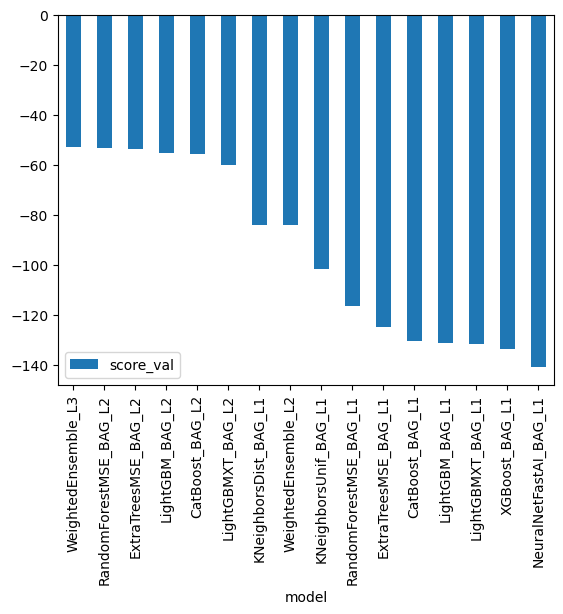

In [11]:
predictor.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [12]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.763947
std        90.123535
min         3.049559
25%        21.185013
50%        62.683937
75%       171.152069
max       363.327698
Name: count, dtype: float64

In [13]:
# How many negative values do we have?
(predictions < 0).sum()

0

In [14]:
# Set them to zero
predictions[predictions < 0] = 0

### Set predictions to submission dataframe, save, and submit

In [15]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [16]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,22.374023
1,2011-01-20 01:00:00,41.041100
2,2011-01-20 02:00:00,45.804092
3,2011-01-20 03:00:00,49.051109
4,2011-01-20 04:00:00,51.741272


In [27]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 636kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [28]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName        date                 description           status    publicScore  privateScore  
--------------  -------------------  --------------------  --------  -----------  ------------  
submission.csv  2024-05-05 02:50:06  first raw submission  complete  1.8043       1.8043        


#### Initial score of `1.8043`

## Exploratory Data Analysis and Creating an additional feature

array([[<Axes: title={'center': 'datetime'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'holiday'}>],
       [<Axes: title={'center': 'workingday'}>,
        <Axes: title={'center': 'weather'}>,
        <Axes: title={'center': 'temp'}>],
       [<Axes: title={'center': 'atemp'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'count'}>, <Axes: >, <Axes: >]],
      dtype=object)

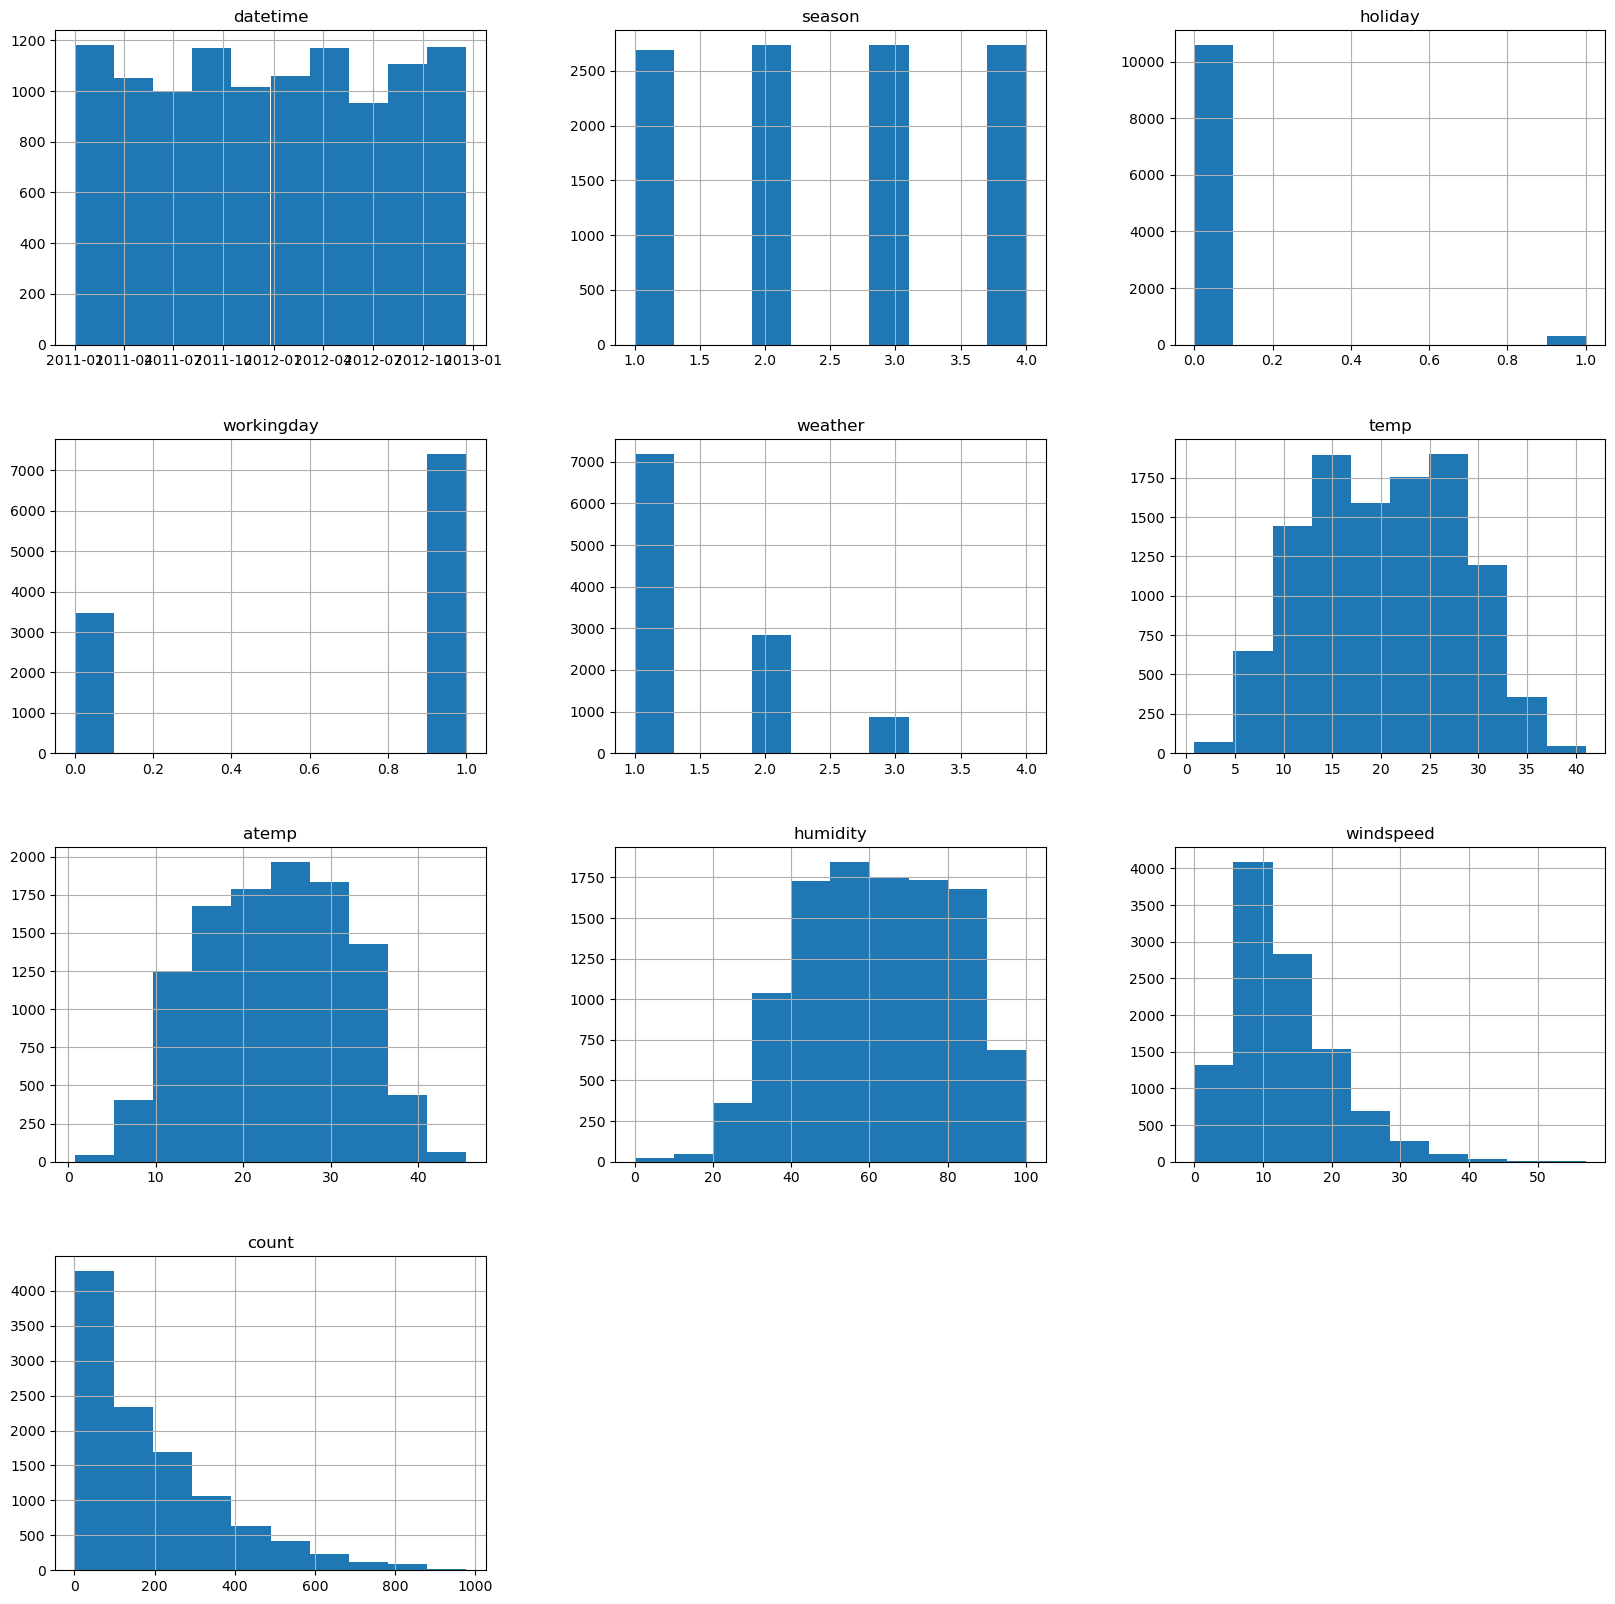

In [29]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis
train.hist(figsize=(20, 20))

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count'],
      dtype='object')


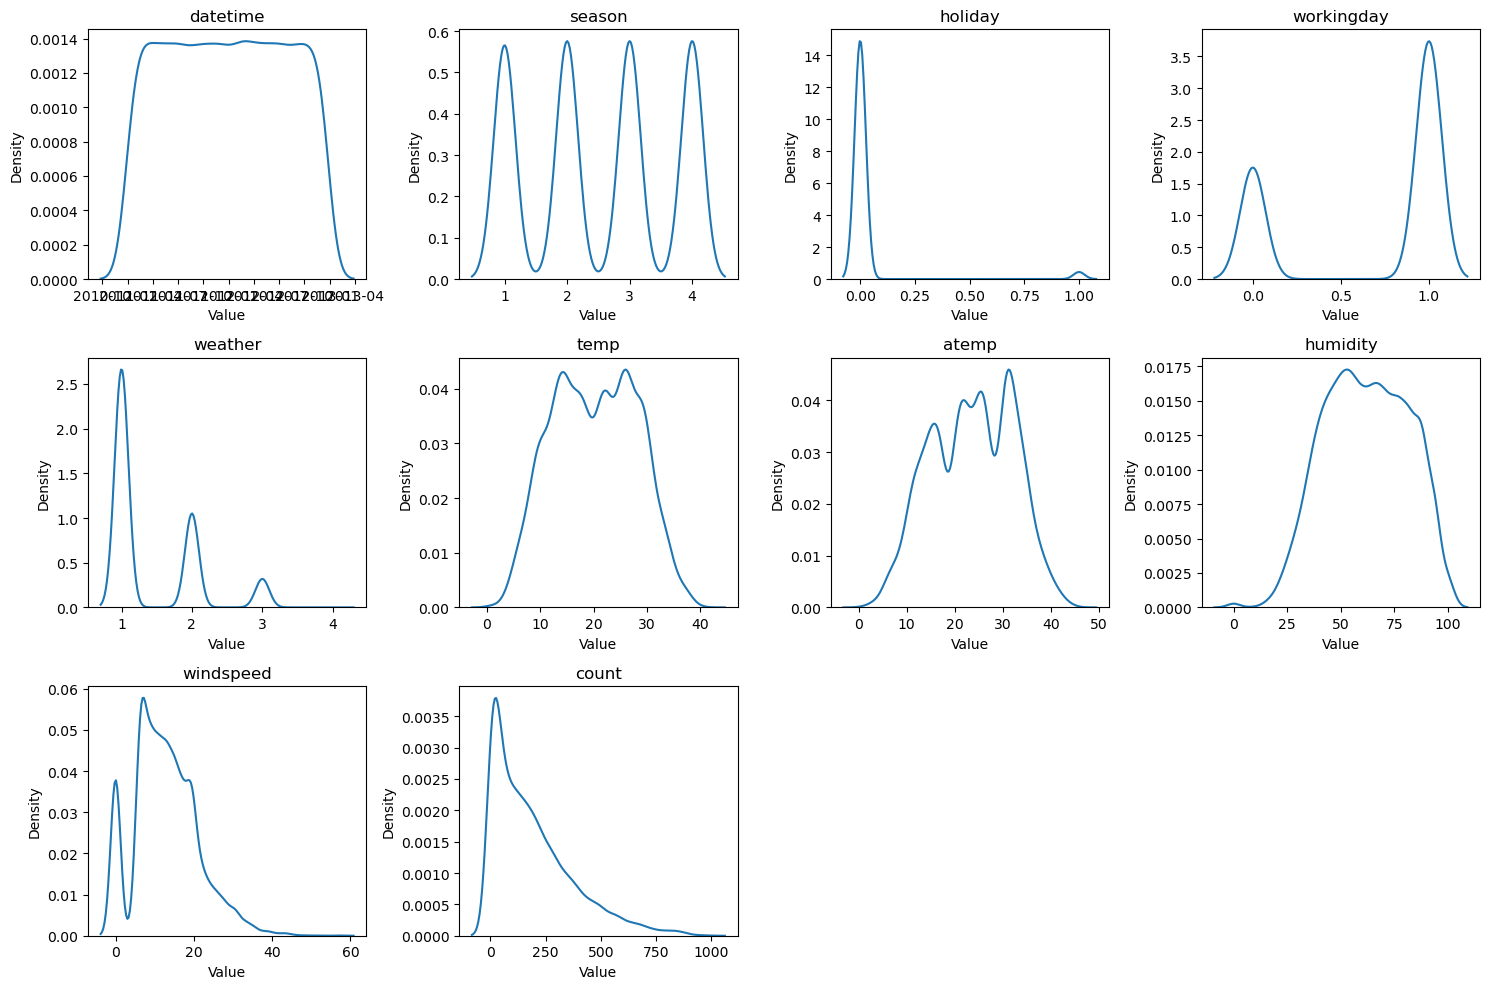

In [9]:
columns_to_plot = train.columns
print(columns_to_plot)
num_cols = 4
num_rows = (len(columns_to_plot) - 1) // num_cols + 1

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten axes array
axes = axes.flatten()

# Loop through each column and create a KDE plot
for i, col in enumerate(columns_to_plot):
    sns.kdeplot(train[col], ax=axes[i])
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Density')

# Hide any unused subplots
for j in range(len(columns_to_plot), num_rows * num_cols):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
plt.show()

In [17]:
# create new features
train["hour"] = train["datetime"].dt.hour.astype("category")
test["hour"] = test["datetime"].dt.hour.astype("category")
train["dayofweek"] = train["datetime"].dt.dayofweek.astype("category")
test["dayofweek"] = test["datetime"].dt.dayofweek.astype("category")
train["month"] = train["datetime"].dt.month.astype("category")
test["month"] = test["datetime"].dt.month.astype("category")
train.drop(columns=["datetime"], inplace=True)
test.drop(columns=["datetime"], inplace=True)
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,dayofweek,month
0,1,0,0,1,9.84,14.395,81,0.0,16,0,5,1
1,1,0,0,1,9.02,13.635,80,0.0,40,1,5,1
2,1,0,0,1,9.02,13.635,80,0.0,32,2,5,1
3,1,0,0,1,9.84,14.395,75,0.0,13,3,5,1
4,1,0,0,1,9.84,14.395,75,0.0,1,4,5,1


## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [18]:
train["season"] = train["season"].astype("category")
test["season"] = test["season"].astype("category")
train["weather"] = train["weather"].astype("category")
test["weather"] = test["weather"].astype("category")
train["holiday"] = train["holiday"].astype("bool")
test["holiday"] = test["holiday"].astype("bool")
train["workingday"] = train["workingday"].astype("bool")
test["workingday"] = test["workingday"].astype("bool")
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,dayofweek,month
0,1,False,False,1,9.84,14.395,81,0.0,16,0,5,1
1,1,False,False,1,9.02,13.635,80,0.0,40,1,5,1
2,1,False,False,1,9.02,13.635,80,0.0,32,2,5,1
3,1,False,False,1,9.84,14.395,75,0.0,13,3,5,1
4,1,False,False,1,9.84,14.395,75,0.0,1,4,5,1


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   season      10886 non-null  category
 1   holiday     10886 non-null  bool    
 2   workingday  10886 non-null  bool    
 3   weather     10886 non-null  category
 4   temp        10886 non-null  float64 
 5   atemp       10886 non-null  float64 
 6   humidity    10886 non-null  int64   
 7   windspeed   10886 non-null  float64 
 8   count       10886 non-null  int64   
 9   hour        10886 non-null  category
 10  dayofweek   10886 non-null  category
 11  month       10886 non-null  category
dtypes: bool(2), category(5), float64(3), int64(2)
memory usage: 501.2 KB


array([[<Axes: title={'center': 'temp'}>,
        <Axes: title={'center': 'atemp'}>],
       [<Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'windspeed'}>],
       [<Axes: title={'center': 'count'}>, <Axes: >]], dtype=object)

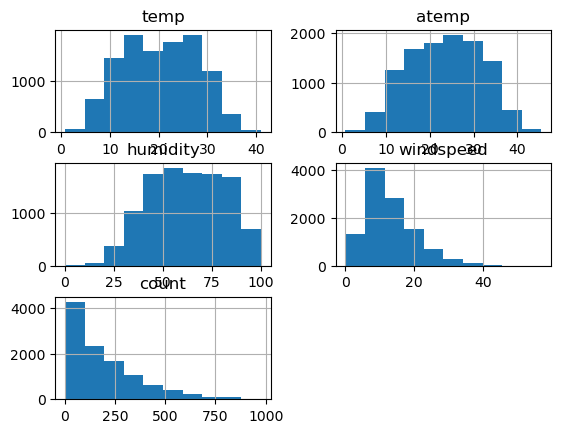

In [20]:
# View histogram of all features again now with the hour feature
train.hist()

## Step 5: Rerun the model with the same settings as before, just with more features

In [35]:
predictor_new_features = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(train, time_limit=600, presets="best_quality")

No path specified. Models will be saved in: "AutogluonModels/ag-20240505_025357"
Presets specified: ['best_quality']
/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240505_025357"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   3.87 GB / 5.36 GB (72.3%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 11
Label Column: c

[1000]	valid_set's rmse: 60.8653
[2000]	valid_set's rmse: 59.9511
[3000]	valid_set's rmse: 59.8687


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 62.4142
[2000]	valid_set's rmse: 61.7971


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 62.2344
[2000]	valid_set's rmse: 61.4028
[3000]	valid_set's rmse: 61.4618


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 61.2434
[2000]	valid_set's rmse: 60.4365


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 63.2189
[2000]	valid_set's rmse: 62.7792


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 60.5326
[2000]	valid_set's rmse: 60.2786


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10140.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 63.0364


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10140.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 57.4287


	-60.8358	 = Validation score   (-root_mean_squared_error)
	37.2s	 = Training   runtime
	4.16s	 = Validation runtime
Fitting model: LightGBM_BAG_L1 ... Training model for up to 353.91s of the 553.91s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 58.4894
[2000]	valid_set's rmse: 58.4109


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 60.7619


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 60.6339


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 60.8336


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 62.5039
[2000]	valid_set's rmse: 62.0442


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 60.6888


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10140.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 62.8619
[2000]	valid_set's rmse: 62.5588


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10140.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 56.9366


	-60.2056	 = Validation score   (-root_mean_squared_error)
	25.84s	 = Training   runtime
	2.75s	 = Validation runtime
Fitting model: RandomForestMSE_BAG_L1 ... Training model for up to 321.94s of the 521.94s of remaining time.
	-64.2687	 = Validation score   (-root_mean_squared_error)
	14.41s	 = Training   runtime
	0.68s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 306.27s of the 506.26s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (
	Ran out of time, early stopping on iteration 1734.
/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: Future

In [21]:
predictor_new_features = TabularPredictor.load("AutogluonModels/ag-20240505_025357")

In [22]:
predictor_new_features.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -58.558175       9.999289  525.868969                0.000913           0.472670            3       True         15
1          CatBoost_BAG_L2  -58.898567       8.812623  485.605734                0.090676         105.933089            2       True         12
2     ExtraTreesMSE_BAG_L2  -58.993851       9.344846  392.382353                0.622899          12.709708            2       True         13
3      WeightedEnsemble_L2  -59.007053       7.837381  371.805987                0.000675           0.604325            2       True          8
4          LightGBM_BAG_L2  -59.583752       8.851998  392.692104                0.130051          13.019459            2       True         10
5   RandomForestMSE_BAG_L2  -59.695722       9.358907  416.932087         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel'},
 'model_performance': {'KNeighborsUnif_BAG_L1': -164.55761532708044,
  'KNeighborsDist_BAG_L1': -179.00930229155557,
  'LightGBMXT_BAG_L1': -60.83578989604188,
  'LightGBM_BAG_L1': -

<Axes: xlabel='model'>

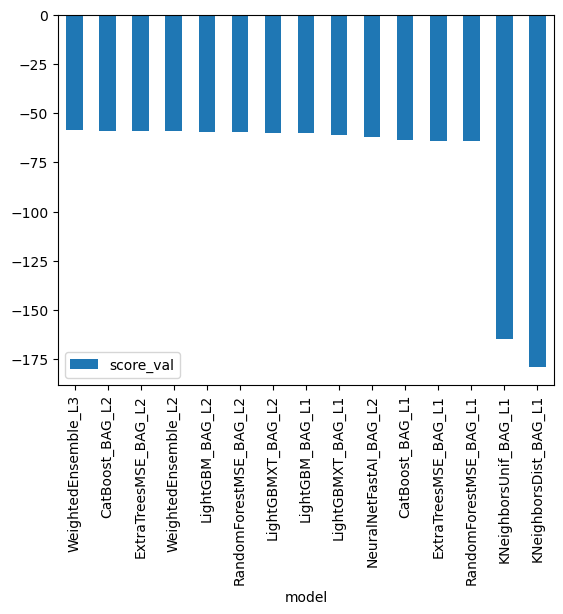

In [23]:
predictor_new_features.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [24]:
# Remember to set all negative values to zero
predictions_new_features = predictor_new_features.predict(test)
predictions_new_features[predictions_new_features < 0] = 0
predictions_new_features.describe()

count    6493.000000
mean      188.363663
std       168.242630
min         0.746031
25%        47.177532
50%       147.765350
75%       277.515808
max       880.497498
Name: count, dtype: float64

In [25]:
# Same submitting predictions
submission_new_features = submission.copy()
submission_new_features["count"] = predictions_new_features
submission_new_features.to_csv("submission_new_features.csv", index=False)

In [40]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_features.csv -m "new features"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 652kB/s]
Successfully submitted to Bike Sharing Demand

In [42]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description           status    publicScore  privateScore  
---------------------------  -------------------  --------------------  --------  -----------  ------------  
submission_new_features.csv  2024-05-05 03:05:13  new features          complete  0.47456      0.47456       
submission.csv               2024-05-05 02:50:06  first raw submission  complete  1.8043       1.8043        


#### New Score of `0.47456`

## Hyper parameter optimization
* There are many options for hyperparameters optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [49]:
hyperparameters = {
    'GBM': {  # LightGBM
        'num_leaves': 40,
        'min_child_samples': 20
    },
    'CAT': {  # CatBoost
        'depth': 6,
        'l2_leaf_reg': 3,
        'learning_rate': 0.1,
        'bagging_temperature': 0.75,
    },
    'XGB': {  # XGBoost
        'max_depth': 6,
        'subsample': 0.75,
        'colsample_bytree': 0.75
    },
    'RF': {  # Random Forest
        'n_estimators': 150,
        'max_depth': None,
        'min_samples_split': 3,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',
    },
    'XT': {  # Extremely Randomized Trees
        'n_estimators': 150,
        'max_depth': None,
        'min_samples_split': 3,
        'min_samples_leaf': 2,
        'max_features': 'sqrt',
    },
    'NN_TORCH': {  # PyTorch Neural Network
        'optimizer': 'AdamW',
        'lr': 0.001,
        'batch_size': 64,
        'num_epochs': 100,
        'layers': [128, 64, 32],
        'dropout': 0.2,
    },
    "FASTAI": {  # Neural Network with FastAI backend
        "num_epochs": 10,
        "learning_rate": 1e-3,
        "batch_size": 64,
        "hidden_units": [128, 64],
        "activation": "relu"
    }
}

# used high_quality instead of best to encorage simpler models that can generelize better
predictor_new_hpo1 = TabularPredictor(label="count",
                                     eval_metric="root_mean_squared_error").fit(
    train, time_limit=600,
    presets="high_quality", hyperparameters=hyperparameters)

No path specified. Models will be saved in: "AutogluonModels/ag-20240505_033512"
Presets specified: ['high_quality']
/opt/conda/lib/python3.10/site-packages/autogluon/core/utils/utils.py:564: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):  # treat None, NaN, INF, NINF as NA
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240505_033512"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   2.61 GB / 5.36 GB (48.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 11
Label Column: c

[1000]	valid_set's rmse: 58.8767


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 59.7476


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 60.4498


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 60.6127


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 60.9973


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 60.9696


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10140.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 62.8643


/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10140.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (


[1000]	valid_set's rmse: 56.3281


	-59.9221	 = Validation score   (-root_mean_squared_error)
	22.48s	 = Training   runtime
	2.27s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ... Training model for up to 374.98s of the 575.02s of remaining time.
	-72.0122	 = Validation score   (-root_mean_squared_error)
	2.0s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 372.6s of the 572.64s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10139.4' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  memory_usage[column] = (
	Ran out of time, early stopping on iteration 2316.
/opt/conda/lib/python3.10/site-packages/autogluon/common/utils/pandas_utils.py:50: FutureWarnin

In [26]:
predictor_new_hpo1 = TabularPredictor.load("AutogluonModels/ag-20240505_033512")

In [27]:
predictor_new_hpo1.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                          model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0           WeightedEnsemble_L3  -57.510153       4.428684  576.849663                0.001066           0.333500            3      False         14
1        NeuralNetFastAI_BAG_L2  -58.146308       3.859632  499.625357                0.339791         103.780946            2      False         12
2               CatBoost_BAG_L2  -58.216382       3.601265  462.233601                0.081424          66.389190            2      False         10
3             ExtraTrees_BAG_L2  -58.635551       3.851077  397.692322                0.331236           1.847910            2      False         11
4                XGBoost_BAG_L2  -58.641482       3.675166  404.498117                0.155325           8.653706            2      False         13
5           WeightedEnsemble_L2  -58.786302 

{'model_types': {'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTrees_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTrees_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L2': 'StackerEnsembleModel_XGBoost',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel',
  'LightGBM_BAG_L1_FULL': 'StackerEnsembleModel_LGB',
  'RandomForest_BAG_L1_FULL': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1_FULL': 'StackerEnsembleModel_CatBoost',
  'ExtraTrees_BAG_L1_FULL': 'StackerEnsembleModel_XT',
  'NeuralN

<Axes: xlabel='model'>

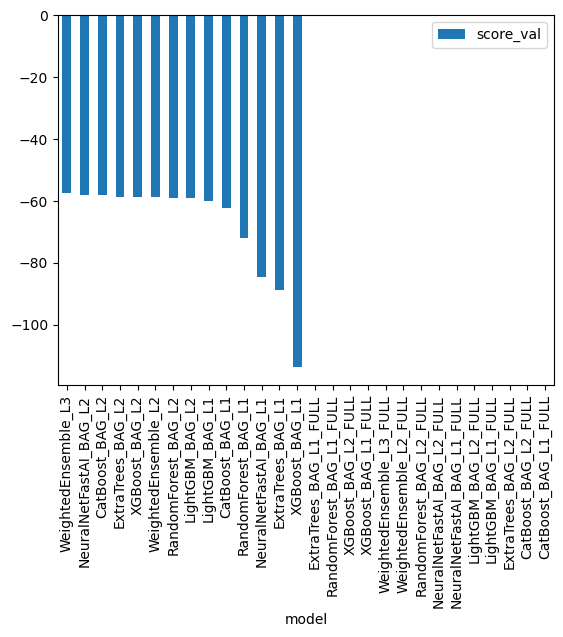

In [29]:
predictor_new_hpo1.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [30]:
# Remember to set all negative values to zero
predictions_new_hpo1 = predictor_new_hpo1.predict(test)
predictions_new_hpo1[predictions_new_hpo1 < 0] = 0
predictions_new_hpo1.describe()

count    6493.000000
mean      191.909897
std       161.414368
min         9.307827
25%        56.589272
50%       151.348175
75%       275.512482
max       869.869934
Name: count, dtype: float64

In [31]:
# Same submitting predictions
submission_new_hpo1 = submission.copy()
submission_new_hpo1["count"] = predictions_new_hpo1
submission_new_hpo1.to_csv("submission_new_hpo1.csv", index=False)

In [55]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo1.csv -m "new features with hyperparameters 1"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 661kB/s]
Successfully submitted to Bike Sharing Demand

In [56]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo.csv       2024-05-05 03:46:13  new features with hyperparameters 1  complete  0.65364      0.65364       
submission_new_features.csv  2024-05-05 03:05:13  new features                         complete  0.47456      0.47456       
submission.csv               2024-05-05 02:50:06  first raw submission                 complete  1.8043       1.8043        


#### New Score of `0.65364`

In [58]:
hyperparameters = {
    "GBM": {  # LightGBM
        "num_leaves": 31,
        "learning_rate": 0.1,
        "min_child_samples": 10,
        "bagging_fraction": 0.8
    },
    'CAT': {  # CatBoost
        'depth': 8,
        'l2_leaf_reg': 3,
        'learning_rate': 0.1,
        'bagging_temperature': 1,
    },
    'XGB': {  # XGBoost
        "eta": 0.1,
        'max_depth': 8,
        'subsample': 0.8,
        'colsample_bytree': 0.8
    },
    'RF': {  # Random Forest
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
    },
    'XT': {  # Extremely Randomized Trees
        'n_estimators': 100,
        'max_depth': None,
        'min_samples_split': 2,
        'min_samples_leaf': 1,
        'max_features': 'sqrt',
    },
    'NN_TORCH': {  # PyTorch Neural Network
        "learning_rate": 1e-3,
        "batch_size": 64,
        "hidden_units": [128, 64],
        "activation": "relu"
    },
    "FASTAI": {  # Neural Network with FastAI backend
        'optimizer': 'ranger',
        'lr': 1e-3,
        'batch_size': 64,
        'num_epochs': 50,
        'layers': [256, 128, 64],
    }
}

predictor_new_hpo2 = TabularPredictor(label="count",
                                     eval_metric="root_mean_squared_error").fit(
    train, time_limit=600,
    presets="best_quality", hyperparameters=hyperparameters)

No path specified. Models will be saved in: "AutogluonModels/ag-20240505_035622"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240505_035622"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   2.14 GB / 5.36 GB (40.0%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 11
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify t

[1000]	valid_set's rmse: 58.0059
[1000]	valid_set's rmse: 60.6437
[1000]	valid_set's rmse: 60.8896
[1000]	valid_set's rmse: 60.8639
[1000]	valid_set's rmse: 60.881
[1000]	valid_set's rmse: 62.5058
[1000]	valid_set's rmse: 57.2898


	-60.0392	 = Validation score   (-root_mean_squared_error)
	15.71s	 = Training   runtime
	1.2s	 = Validation runtime
Fitting model: RandomForest_BAG_L1 ... Training model for up to 381.08s of the 581.11s of remaining time.
	-69.3104	 = Validation score   (-root_mean_squared_error)
	1.94s	 = Training   runtime
	0.25s	 = Validation runtime
Fitting model: CatBoost_BAG_L1 ... Training model for up to 378.7s of the 578.73s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 1459.
	Ran out of time, early stopping on iteration 1551.
	Ran out of time, early stopping on iteration 1667.
	Ran out of time, early stopping on iteration 1694.
	Ran out of time, early stopping on iteration 1658.
	Ran out of time, early stopping on iteration 1840.
	Ran out of time, early stopping on iteration 1942.
	Ran out of time, early stopping on iteration 2352.
	-61.2825	 = Validation score   (-root_mean_squared_err

In [32]:
predictor_new_hpo2 = TabularPredictor.load("AutogluonModels/ag-20240505_035622")

<Axes: xlabel='model'>

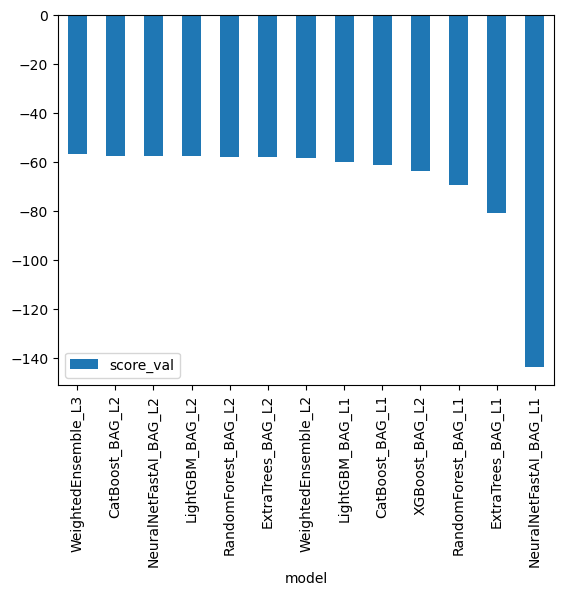

In [33]:
predictions_new_hpo2 = predictor_new_hpo2.predict(test)
predictions_new_hpo2[predictions_new_hpo2 < 0] = 0
predictor_new_hpo2.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [34]:
submission_new_hpo2 = submission.copy()
submission_new_hpo2["count"] = predictions_new_hpo2
submission_new_hpo2.to_csv("submission_new_hpo2.csv", index=False)

In [80]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo2.csv -m "new features with hyperparameters 2"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 701kB/s]
Successfully submitted to Bike Sharing Demand

In [84]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 6

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo1.csv      2024-05-05 05:20:53  new features with hyperparameters 1  complete  0.52443      0.52443       
submission_new_hpo3.csv      2024-05-05 05:18:39  new features with hyperparameters    complete  0.48337      0.48337       
submission_new_hpo.csv       2024-05-05 05:18:19  new features with hyperparameters 3  complete  0.65364      0.65364       
submission_new_hpo.csv       2024-05-05 04:07:09  new features with hyperparameters    complete  0.65364      0.65364       


#### New Score of `0.52443`

<Axes: xlabel='model'>

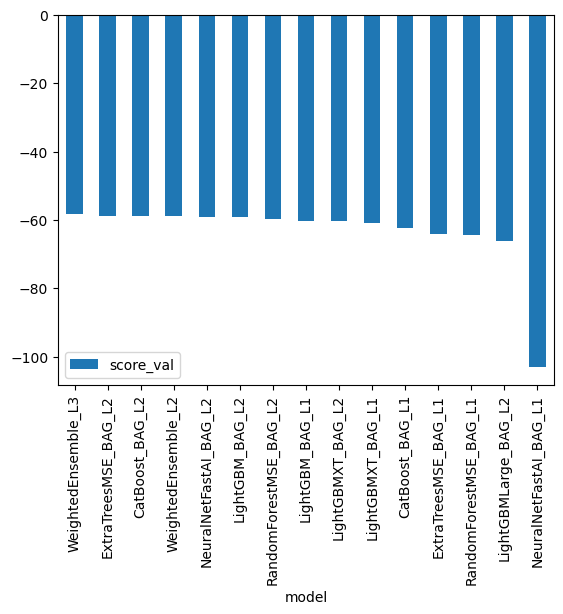

In [35]:
predictor_new_hpo3 = TabularPredictor.load("AutogluonModels/ag-20240505_050218")
predictions_new_hpo3 = predictor_new_hpo3.predict(test)
predictions_new_hpo3[predictions_new_hpo3 < 0] = 0
submission_new_hpo3 = submission.copy()
submission_new_hpo3["count"] = predictions_new_hpo3
submission_new_hpo3.to_csv("submission_new_hpo3.csv", index=False)
predictor_new_hpo3.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

#### New Score of `0.48337`

In [36]:
# A bit more feature engeeniring
dummies_cols = ["season", "weather", "holiday", "workingday"]
train = pd.get_dummies(train, columns=dummies_cols)
test = pd.get_dummies(test, columns=dummies_cols)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   temp              10886 non-null  float64 
 1   atemp             10886 non-null  float64 
 2   humidity          10886 non-null  int64   
 3   windspeed         10886 non-null  float64 
 4   count             10886 non-null  int64   
 5   hour              10886 non-null  category
 6   dayofweek         10886 non-null  category
 7   month             10886 non-null  category
 8   season_1          10886 non-null  bool    
 9   season_2          10886 non-null  bool    
 10  season_3          10886 non-null  bool    
 11  season_4          10886 non-null  bool    
 12  weather_1         10886 non-null  bool    
 13  weather_2         10886 non-null  bool    
 14  weather_3         10886 non-null  bool    
 15  weather_4         10886 non-null  bool    
 16  holiday_False     1088

In [13]:
hyperparameters = {
	'GBM': [{'extra_trees': True, 'ag_args': {'name_suffix': 'XT'}}, {}, 'GBMLarge'],
	'CAT': {},
	'FASTAI': {},
	'RF': [{'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}}],
	'XT': [{'criterion': 'squared_error', 'ag_args': {'name_suffix': 'MSE', 'problem_types': ['regression']}}],
}
hyperparameter_tune_kwargs = {
    "searcher": "random",
    "scheduler" : "local",
    "num_trials": 5, 
    "num_folds": 5
}
    
predictor_new_hpo4 = TabularPredictor(
    label="count", eval_metric="root_mean_squared_error").fit(
    train, time_limit=600,
    presets="best_quality", auto_stack=True, hyperparameters=hyperparameters,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs)

No path specified. Models will be saved in: "AutogluonModels/ag-20240505_135737"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=1, num_bag_folds=8, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20240505_135737"
AutoGluon Version:  0.8.2
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Sat Mar 23 09:49:55 UTC 2024
Disk Space Avail:   1.64 GB / 5.36 GB (30.7%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.
Train Data Rows:    10886
Train Data Columns: 19
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify t

  0%|          | 0/5 [00:00<?, ?it/s]

Will use sequential fold fitting strategy because import of ray failed. Reason: ray is required to train folds in parallel for TabularPredictor or HPO for MultiModalPredictor. A quick tip is to install via `pip install ray==2.6.3`
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 60.4597
[2000]	valid_set's rmse: 59.3295
[3000]	valid_set's rmse: 59.2683


	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 57.9304


	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 61.3866


	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 65.3432


	Ran out of time, early stopping on iteration 1235. Best iteration is:
	[1235]	valid_set's rmse: 64.0593
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
Fitted model: LightGBMXT_BAG_L1/T5 ...
	-62.6675	 = Validation score   (-root_mean_squared_error)
	20.63s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L1 ... Tuning model for up to 51.39s of the 554.41s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 58.0432
[2000]	valid_set's rmse: 57.4334
[1000]	valid_set's rmse: 60.476
[1000]	valid_set's rmse: 59.9065
[2000]	valid_set's rmse: 59.522
[1000]	valid_set's rmse: 60.7896
[2000]	valid_set's rmse: 60.4502
[1000]	valid_set's rmse: 62.339
[1000]	valid_set's rmse: 60.6147
[1000]	valid_set's rmse: 62.9258
[2000]	valid_set's rmse: 62.4428
[1000]	valid_set's rmse: 57.2042


	Stopping HPO to satisfy time limit...
Fitted model: LightGBM_BAG_L1/T1 ...
	-59.9564	 = Validation score   (-root_mean_squared_error)
	27.43s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: RandomForestMSE_BAG_L1 ... Tuning model for up to 51.39s of the 526.88s of remaining time.
	No hyperparameter search space specified for RandomForestMSE_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: RandomForestMSE_BAG_L1 ...
	-64.1705	 = Validation score   (-root_mean_squared_error)
	17.84s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: CatBoost_BAG_L1 ... Tuning model for up to 51.39s of the 509.0s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 405.
	Ran out of time, early stopping on iteration 282.
	Ran out of time, early stopping on iteration 494.
	Ran out of time, early stopping on iteration 680.
	Ran out of time, early stopping on iteration 580.
	Ran out of time, early stopping on iteration 666.
	Ran out of time, early stopping on iteration 610.
	Ran out of time, early stopping on iteration 784.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L1/T1 ...
	-68.2054	 = Validation score   (-root_mean_squared_error)
	44.7s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesMSE_BAG_L1 ... Tuning model for up to 51.39s of the 464.25s of remaining time.
	No hyperparameter search space specified for ExtraTreesMSE_BAG_L1. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesMSE_BAG_L1 ...
	-64.1477	 = 

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 3)
	Ran out of time, stopping training early. (Stopping on epoch 7)
	Ran out of time, stopping training early. (Stopping on epoch 7)
	Ran out of time, stopping training early. (Stopping on epoch 8)
	Ran out of time, stopping training early. (Stopping on epoch 8)
	Ran out of time, stopping training early. (Stopping on epoch 8)
	Ran out of time, stopping training early. (Stopping on epoch 11)
	Ran out of time, stopping training early. (Stopping on epoch 12)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetFastAI_BAG_L1/T1 ...
	-70.9357	 = Validation score   (-root_mean_squared_error)
	44.16s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L1 ... Training model for up to 51.39s of the 407.25s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrat

[1000]	valid_set's rmse: 57.9568
[2000]	valid_set's rmse: 57.6319


	Ran out of time, early stopping on iteration 2402. Best iteration is:
	[1875]	valid_set's rmse: 57.6007
	Time limit exceeded... Skipping LightGBMLarge_BAG_L1.
Completed 1/20 k-fold bagging repeats ...
Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.0s of the 400.18s of remaining time.
	-59.0798	 = Validation score   (-root_mean_squared_error)
	0.44s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting 7 L2 models ...
Hyperparameter tuning model: LightGBMXT_BAG_L2 ... Tuning model for up to 51.39s of the 399.68s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 59.7105


	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy


[1000]	valid_set's rmse: 58.0537
[2000]	valid_set's rmse: 57.1219
[3000]	valid_set's rmse: 56.8053
[4000]	valid_set's rmse: 56.6133
[5000]	valid_set's rmse: 56.5333
[6000]	valid_set's rmse: 56.4737
[7000]	valid_set's rmse: 56.4456
[8000]	valid_set's rmse: 56.4317


	Ran out of time, early stopping on iteration 8234. Best iteration is:
	[8211]	valid_set's rmse: 56.4295
	Stopping HPO to satisfy time limit...
Fitted model: LightGBMXT_BAG_L2/T1 ...
	-60.7431	 = Validation score   (-root_mean_squared_error)
	13.8s	 = Training   runtime
	0.0s	 = Validation runtime
Fitted model: LightGBMXT_BAG_L2/T2 ...
	-60.7773	 = Validation score   (-root_mean_squared_error)
	44.99s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: LightGBM_BAG_L2 ... Tuning model for up to 51.39s of the 340.75s of remaining time.


  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 252. Best iteration is:
	[252]	valid_set's rmse: 68.8408
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 259. Best iteration is:
	[33]	valid_set's rmse: 61.7822
	Ran out of time, early stopping on iteration 278. Best iteration is:
	[34]	valid_set's rmse: 63.1518
	Ran out of time, early stopping on iteration 239. Best iteration is:
	[38]	valid_set's rmse: 57.9356
	Ran out of time, early stopping on iteration 168. Best iteration is:
	[39]	valid_set's rmse: 59.9072
	Ran out of time, early stopping on iteration 280

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, early stopping on iteration 343.
	Ran out of time, early stopping on iteration 403.
	Ran out of time, early stopping on iteration 375.
	Ran out of time, early stopping on iteration 420.
	Ran out of time, early stopping on iteration 359.
	Ran out of time, early stopping on iteration 396.
	Ran out of time, early stopping on iteration 425.
	Stopping HPO to satisfy time limit...
Fitted model: CatBoost_BAG_L2/T1 ...
	-59.2323	 = Validation score   (-root_mean_squared_error)
	43.91s	 = Training   runtime
	0.0s	 = Validation runtime
Hyperparameter tuning model: ExtraTreesMSE_BAG_L2 ... Tuning model for up to 51.39s of the 208.81s of remaining time.
	No hyperparameter search space specified for ExtraTreesMSE_BAG_L2. Skipping HPO. Will train one model based on the provided hyperparameters.
Fitted model: ExtraTreesMSE_BAG_L2 ...
	-59.1198	 = Validation score   (-root_mean_squared_error)
	15.

  0%|          | 0/5 [00:00<?, ?it/s]

	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrategy
	Ran out of time, stopping training early. (Stopping on epoch 11)
	Ran out of time, stopping training early. (Stopping on epoch 7)
	Ran out of time, stopping training early. (Stopping on epoch 8)
	Ran out of time, stopping training early. (Stopping on epoch 7)
	Ran out of time, stopping training early. (Stopping on epoch 8)
	Ran out of time, stopping training early. (Stopping on epoch 8)
	Ran out of time, stopping training early. (Stopping on epoch 10)
	Ran out of time, stopping training early. (Stopping on epoch 9)
	Stopping HPO to satisfy time limit...
Fitted model: NeuralNetFastAI_BAG_L2/T1 ...
	-60.7259	 = Validation score   (-root_mean_squared_error)
	44.41s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: LightGBMLarge_BAG_L2 ... Training model for up to 51.39s of the 148.98s of remaining time.
	Fitting 8 child models (S1F1 - S1F8) | Fitting with SequentialLocalFoldFittingStrat

In [37]:
predictor_new_hpo4 = TabularPredictor.load("AutogluonModels/ag-20240505_135737")

<Axes: xlabel='model'>

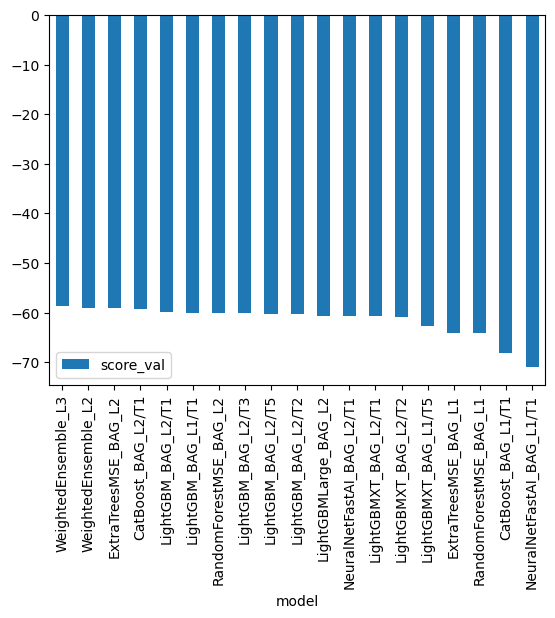

In [38]:
predictions_new_hpo4 = predictor_new_hpo4.predict(test)
predictions_new_hpo4[predictions_new_hpo4 < 0] = 0
predictor_new_hpo4.leaderboard(silent=True).plot(kind='bar', x='model', y='score_val')

In [39]:
submission_new_hpo4 = submission.copy()
submission_new_hpo4["count"] = predictions_new_hpo4
submission_new_hpo4.to_csv("submission_new_hpo4.csv", index=False)

In [28]:
!kaggle competitions submit -c bike-sharing-demand -f submission_new_hpo4.csv -m "new features with hyperparameters 4"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 722kB/s]
Successfully submitted to Bike Sharing Demand

In [31]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 10

fileName                     date                 description                          status    publicScore  privateScore  
---------------------------  -------------------  -----------------------------------  --------  -----------  ------------  
submission_new_hpo4.csv      2024-05-05 14:16:34  new features with hyperparameters 4  complete  0.47159      0.47159       
submission_new_hpo1.csv      2024-05-05 05:20:53  new features with hyperparameters 1  complete  0.52443      0.52443       
submission_new_hpo3.csv      2024-05-05 05:18:39  new features with hyperparameters    complete  0.48337      0.48337       
submission_new_hpo.csv       2024-05-05 05:18:19  new features with hyperparameters 3  complete  0.65364      0.65364       
submission_new_hpo.csv       2024-05-05 04:07:09  new features with hyperparameters    complete  0.65364      0.65364       
submission_new_hpo.csv       2024-05-05 03:46:13  new features with hyperparameters 1  complete  0.65364      0.65364       


#### New Score of `0.47159`

## Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

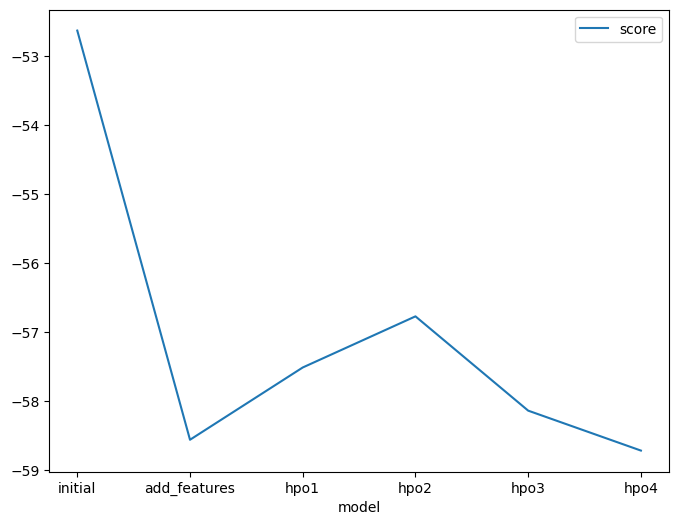

In [40]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model": ["initial", "add_features", "hpo1", "hpo2", "hpo3", "hpo4"],
        "score": [predictor.leaderboard(silent=True)['score_val'][0],
                  predictor_new_features.leaderboard(silent=True)['score_val'][0],
                  predictor_new_hpo1.leaderboard(silent=True)['score_val'][0],
                 predictor_new_hpo2.leaderboard(silent=True)['score_val'][0],
                 predictor_new_hpo3.leaderboard(silent=True)['score_val'][0],
                 predictor_new_hpo4.leaderboard(silent=True)['score_val'][0]]
    }
).plot(x="model", y="score", figsize=(8, 6)).get_figure()
fig.savefig('train_graph.png')

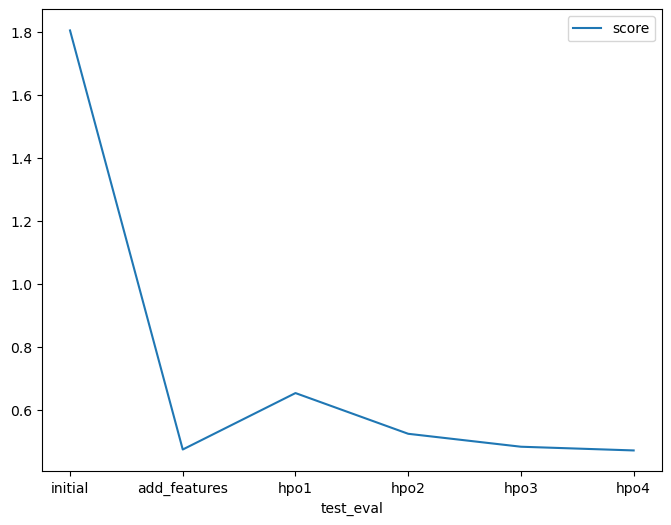

In [41]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "test_eval": ["initial", "add_features", "hpo1", "hpo2", "hpo3", "hpo4"],
        "score": [1.8043, 0.47456, 0.65364, 0.52443, 0.48337, 0.47159]
    }
).plot(x="test_eval", y="score", figsize=(8, 6)).get_figure()
fig.savefig('test_graph.png')